# Optimal mapping - comparison with MCMC

Comparison of KL vs.:
1. Numner of iteration/run time
2. Number of unique states

# TODO:
1. Structure MCMC
2. Order MCMC
3. Partition MCMC
4. Compare with ground truth



In [1]:
# Imports
import os
import datetime
import numpy as np

from mcmc.scores.bge import BGeScore
from mcmc.proposals.graph.graph_proposal import GraphProposal
from mcmc.data.synthetic import SyntheticDataset

from mcmc.mcmc.structure_mcmc import StructureMCMC

import pickle

import pandas as pd

from mcmc.inference.posterior import *

import time
import csv

from tqdm.notebook import trange




In [2]:
num_nodes = 5
node_labels = [f"X{i + 1}" for i in range(num_nodes)]
degree = 2  # erdos-renyi sparsity - equivalent to 0.75
noise_scale = 0.5


In [3]:
def genarate_DAG(n: int, p: float, random_seed: int = None):

    if random_seed is not None:
        np.random.seed(random_seed)

    adjmat = np.zeros((n, n))
    adjmat[np.tril_indices_from(adjmat, k=-1)] = np.random.binomial(1, p, size=int(n * (n - 1) / 2))
    return adjmat

In [4]:
true_dag = genarate_DAG(num_nodes, p=0.5)
print(true_dag)

print(f"Is a dag? {not (has_cycle(true_dag))}")

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0.]]
Is a dag? True


# Generate data

In [5]:
num_obsv = 200
sdj = SyntheticDataset(num_nodes, num_obsv, node_labels, degree, noise_scale=noise_scale)

true_dag = sdj.simulate_random_dag(num_nodes, degree, "erdos-renyi")


data = sdj.data

data.to_csv("./temp.csv", index=False)

In [6]:
sdj.true_dag

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0.]])

In [7]:
data = pd.read_csv("./temp.csv")

node_labels = list(data.columns)

In [8]:
initial_graph = genarate_DAG(num_nodes, p=0.5)
print(f"Is initial_graph a dag? {not (has_cycle(initial_graph))}")

print(initial_graph)


Is initial_graph a dag? True
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0.]]


In [9]:
# Calc ground truth

all_dags = generate_all_dags(data, BGeScore, gen_augmented_priors=False)
true_distr = compute_true_distribution(all_dags, with_aug_prior=False)

Total 5 node DAGs generated = 29281


In [10]:


{f"KL_OM_accepted_{exp_i}": KL_OM_accepted_res}


NameError: name 'exp_i' is not defined

In [ ]:
ddd2 = '00000 10000 11010 11000 01010'


In [ ]:
ddd3 = '00001 00100 01000 10010 10000'

# Structure MCMC

In [11]:
proposal_object = GraphProposal(initial_graph, whitelist=None, blacklist=None)
score_object = BGeScore(data=data, incidence=initial_graph)

In [12]:
max_iter = 1000
pi = 0.1
print("Starting MCMC...")
start = time.time()

mcmc_obj = StructureMCMC(initial_graph, max_iter, proposal_object, score_object)
mcmc_res, accept_rate = mcmc_obj.run()

Starting MCMC...


In [13]:
graph_list = mcmc_obj.get_mcmc_res_graphs(mcmc_res)

In [14]:
ddd = generate_key_from_adj_matrix(graph_list[1])

print(ddd)

00000 10000 11000 00100 01110


In [15]:
true_distr[ddd]

1.0886107763757397e-12

In [16]:
print(true_distr[generate_key_from_adj_matrix(mcmc_res[0]['graph'])])


1.0886107763757397e-12


In [17]:
mcmc_res[101]

{'graph': array([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.]]),
 'score': -1136.1834440986238,
 'operation': array(['reverse_edge'], dtype='<U12'),
 'accepted': 1,
 'Q_Gprop_Gcurr': 0.05555555555555555,
 'Q_Gcurr_Gprop': 0.06666666666666667,
 'score_Gprop': -1136.1834440986238,
 'score_Gcurr': -1136.1834440986238,
 'acceptance_prob': 0,
 'Gprop': array([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.]])}

In [18]:
def KL_MCMC(MCMC_dict, true_dist, n):
    """
    MCMC_dict: Dictionary with the visited graph and counts
    true_dist: the true distribution
    n: number of iterates
    """

    KL = 0
    for k, mcmc_count in MCMC_dict.items():
        p_approx = mcmc_count / n
        KL += p_approx * np.log(p_approx / true_dist[k])
    return KL


In [19]:
def KL_OM(unique_graphs, unique_scores, true_dist):
    """
    unique_graphs: A list with the visited graph
    unique_scores: A list with scores of visited graph
    true_dist: the true distribution
    """

    KL = 0

    # Prevents overflow during exponentiation by substracting
    max_score = max(unique_scores)

    p_approx_vec = np.asarray(unique_scores) - max_score
    p_approx_vec = np.exp(p_approx_vec)
    p_approx_vec /= np.sum(p_approx_vec)

    for k, p_approx in zip(unique_graphs, p_approx_vec):
        KL += p_approx * np.log(p_approx / true_dist[k])

    return KL





In [20]:

def KL_comparison_OM_MCMC(mcmc_results, ground_truth_distribution):
    graph_mcmc_count = {}
    unique_graph_id = []  # needed to handle overflow/underflow in computing normalization factor
    unique_accepted_graph_id = []  # accepted only
    unique_scores = []  # needed to handle overflows
    unique_accepted_scores = []  # needed to handle overflows


    KL_MCMC_t = []
    KL_OM_t = []
    KL_OM_accepted_only_t = []

    max_mcmc_iter = len(mcmc_results)
    for i in range(max_mcmc_iter):
        res = mcmc_results[i]
        if "Gprop" in res.keys():
            graph_prop = generate_key_from_adj_matrix(res['Gprop'])
            score_prop = res['score_Gprop']
        else:
            graph_prop = None


        graph_id = generate_key_from_adj_matrix(res['graph']) # Accepted graph/state
        score = res['score'] # Accepted score
        # Score is log of the true score

        graph_mcmc_count[graph_id] = graph_mcmc_count[graph_id] +1 if graph_id in graph_mcmc_count else 1

        # OM update
        if not(graph_id in unique_graph_id):
            # When a proposal is accepted and was never added before
            unique_graph_id.append(graph_id)
            unique_scores.append(score)
        elif graph_prop is not None and not(graph_prop in unique_graph_id):
            # Looking at proposal
            unique_graph_id.append(graph_prop)
            unique_scores.append(score_prop)

        # OM update - accepted graphs
        if not(graph_id in unique_accepted_graph_id):
            # When a proposal is accepted and was never added before
            unique_accepted_graph_id.append(graph_id)
            unique_accepted_scores.append(score)


        KL_OM_t.append(KL_OM(unique_graph_id, unique_scores, ground_truth_distribution))
        KL_OM_accepted_only_t.append(KL_OM(unique_accepted_graph_id, unique_accepted_scores, ground_truth_distribution))
        KL_MCMC_t.append(KL_MCMC(graph_mcmc_count, ground_truth_distribution, i + 1))

        # print(f"{len(unique_accepted_graph_id)} - {len(unique_accepted_graph_id)}")

    return KL_MCMC_t, KL_OM_t, KL_OM_accepted_only_t






In [ ]:
import matplotlib.pyplot as plt


KL_MCMC_res, KL_OM_res, KL_OM_accepted_res = KL_comparison_OM_MCMC(mcmc_res, true_distr)

plt.semilogy([i for i in range(len(mcmc_res))], KL_MCMC_res, label='MCMC')
plt.semilogy([i for i in range(len(mcmc_res))], KL_OM_res, label='OM')
plt.semilogy([i for i in range(len(mcmc_res))], KL_OM_accepted_res, label='OM - accepted only')
plt.legend()
plt.xlabel("#Iteration")
plt.ylabel(r"$KL$")


In [ ]:
plt.semilogy([i for i in range(len(mcmc_res))], np.asarray(KL_MCMC_res) - np.asarray(KL_OM_res),
             label=r"$KL_{MCMC} - KL_{OM}$")
plt.xlabel("#Iteration")
plt.ylabel(r"$KL_{MCMC} - KL_{OM}$")


In [31]:
n_exp = 2
num_nodes = 5
node_labels = [f"X{i + 1}" for i in range(num_nodes)]
noise_scale = 1.
score_type = BGeScore
mcmc_iter = 1000
degree = 3  # erdos-renyi sparsity - equivalent to 0.75
graph_type ="erdos-renyi"

DIRPATH = os.path.abspath("")
MAINRESPATH = os.path.join(DIRPATH, 'om_results')
os.makedirs(MAINRESPATH, exist_ok=True)

RESPATH = os.path.join(MAINRESPATH, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(RESPATH, exist_ok=True)

# Synthetic data generator - creating here just to same internal settings for generating data
sdj = SyntheticDataset(num_nodes, num_obsv, node_labels, degree, noise_scale=noise_scale, true_dag=true_dag)

# Save metadata
metadata_dict = {"Num_experiments": n_exp,
                 "num_nodes": num_nodes,
                 "noise_scale": noise_scale,
                 "w_range": sdj.w_range,
                 "score_type": type(score_type).__name__,
                 "MCMC_start_point": 'random',
                 "mcmc_iter": mcmc_iter,
                 "graph_type": graph_type,
                 "dag_sparse_degree": degree
                 }

MCMC_results_dict = {}
OM_results_dict = {}
OM_accepted_results_dict = {}

with open(os.path.join(RESPATH, 'metadata.csv'), 'w', newline="") as csvfile:
    w = csv.DictWriter(csvfile, metadata_dict.keys())
    w.writeheader()
    w.writerow(metadata_dict)

t = trange(n_exp, desc='Bar desc', leave=True)
for exp_i in t:
    print(f"Experiment: {exp_i}")
    # Generate true dag
    t.set_description("%i: Generate true DAG" % exp_i)
    t.refresh()
    time.sleep(0.01)
    print(f"{exp_i}: Generate true DAG")

    sdj = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obsv, node_labels=node_labels, degree=degree, noise_scale=noise_scale, graph_type=graph_type)

    true_dag = sdj.adj_mat.values
    print(true_dag)

    # save dag to file
    np.savetxt(os.path.join(RESPATH, f"true_DAG_{exp_i}.csv"), true_dag, delimiter=',', fmt='%d')

    assert not (has_cycle(true_dag)), "not a DAG"

    # Generate data based on the true DAG
    t.set_description("%i: Generate data" % exp_i)
    t.refresh()
    time.sleep(0.01)
    print(f"{exp_i}: Generate data")


    data = sdj.data
    # save data to file
    np.savetxt(os.path.join(RESPATH, f"data_{exp_i}.csv"), data, delimiter=',')

    # Ground truth distribution
    t.set_description("%i: Generate ground truth" % exp_i)
    t.refresh()
    time.sleep(0.01)
    print(f"{exp_i}: Generate ground truth")
    all_dags = generate_all_dags(data, score_type, gen_augmented_priors=False)
    true_distr = compute_true_distribution(all_dags, with_aug_prior=False)

    # MCMC
    t.set_description("%i: MCMC" % exp_i)
    t.refresh()
    time.sleep(0.5)
    print(f"{exp_i}: MCMC")
    if metadata_dict['MCMC_start_point'] == 'random':
        initial_graph = genarate_DAG(num_nodes, p=0.5)
    else:
        raise ValueError

    np.savetxt(os.path.join(RESPATH, f"MCMC_initial_graph_{exp_i}.csv"), initial_graph, delimiter=',', fmt='%d')
    proposal_object = GraphProposal(initial_graph, whitelist=None, blacklist=None)
    score_object = score_type(data=data, incidence=initial_graph)

    mcmc_obj = StructureMCMC(initial_graph, mcmc_iter, proposal_object, score_object)
    mcmc_res, accept_rate = mcmc_obj.run()

    t.set_description("%i: KL comparison" % exp_i)
    t.refresh()
    time.sleep(0.01)
    KL_MCMC_res, KL_OM_res, KL_OM_accepted_res = KL_comparison_OM_MCMC(mcmc_res, true_distr)

    MCMC_results_dict.update({f"KL_MCMC_{exp_i}": KL_MCMC_res})
    OM_results_dict.update({f"KL_OM_{exp_i}": KL_OM_res})
    OM_accepted_results_dict.update({f"KL_OM_accepted_{exp_i}": KL_OM_accepted_res})

    df = pd.DataFrame(MCMC_results_dict)
    df.to_csv(os.path.join(RESPATH, 'MCMC_KL_results.csv'), index=True)
    df = pd.DataFrame(OM_results_dict)
    df.to_csv(os.path.join(RESPATH, 'OM_KL_results.csv'), index=True)
    df = pd.DataFrame(OM_accepted_results_dict)
    df.to_csv(os.path.join(RESPATH, 'OM_KL_accepted_only_results.csv'), index=True)

    # For debugging purposes
    graph_list = mcmc_obj.get_mcmc_res_graphs( mcmc_res )
    score_list = mcmc_obj.get_mcmc_res_scores( mcmc_res )


    with open(os.path.join(RESPATH, f'MCMC_results_{exp_i}.pkl'), 'wb') as f:
        pickle.dump(graph_list, f)

    with open(os.path.join(RESPATH, f'score_results_{exp_i}.pkl'), 'wb') as f:
        pickle.dump(score_list, f)



Bar desc:   0%|          | 0/2 [00:00<?, ?it/s]

Experiment: 0
0: Generate true DAG
[[0 0 0 1 0]
 [1 0 1 1 0]
 [1 0 0 1 0]
 [0 0 0 0 0]
 [1 1 1 0 0]]
0: Generate data
0: Generate ground truth
Total 5 node DAGs generated = 29281
0: MCMC
Experiment: 1
1: Generate true DAG
[[0 1 0 1 0]
 [0 0 0 0 1]
 [1 0 0 1 1]
 [0 1 0 0 0]
 [0 0 0 0 0]]
1: Generate data
1: Generate ground truth
Total 5 node DAGs generated = 29281
1: MCMC


In [ ]:
df.shape

In [22]:
df_MCMC = pd.read_csv(os.path.join(RESPATH, 'MCMC_KL_results.csv'), index_col=0)
df_OM = pd.read_csv(os.path.join(RESPATH, 'OM_KL_results.csv'), index_col=0)




In [23]:
quantiles = [0.05, 0.95]

MCMC_mean = df_MCMC.mean(axis=1)
MCMC_std = df_MCMC.std(axis=1)

MCMC_quantiles = df_MCMC.apply(lambda row: row.quantile(quantiles), axis=1)

OM_mean = df_OM.mean(axis=1)
OM_std = df_OM.std(axis=1)
OM_quantiles = df_OM.apply(lambda row: row.quantile(quantiles), axis=1)

OM_quantiles

,0.05,0.95
0,31.687786,591.775360
1,26.562505,556.247353
2,26.545636,482.182173
3,26.481100,473.314345
4,6.985271,461.713957
...,...,...
99995,0.000730,0.004395
99996,0.000730,0.004395
99997,0.000730,0.004395
99998,0.000730,0.004395


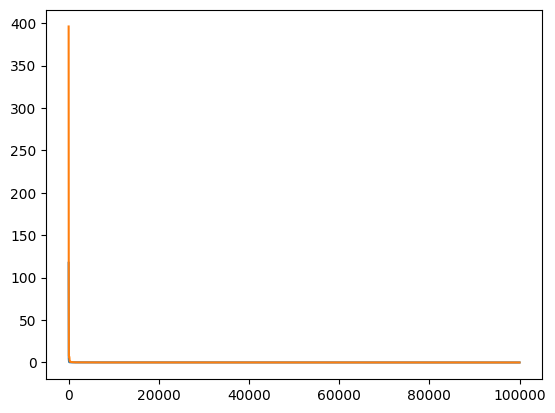

In [24]:
plt.plot(df_OM.iloc[:,0])
plt.plot(df_OM.iloc[:,1])

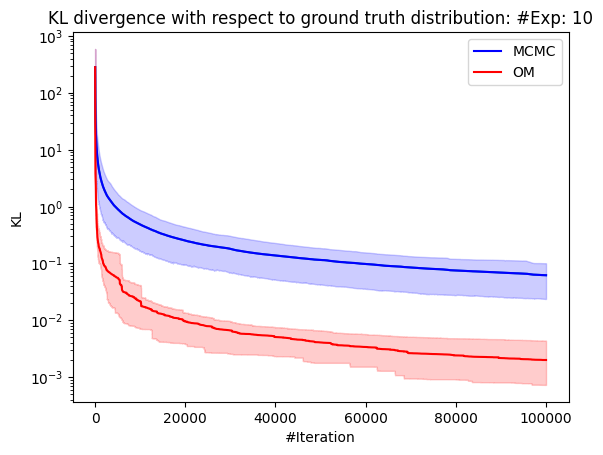

In [25]:
plt.plot(MCMC_mean)
plt.plot(MCMC_mean, color='blue', label='MCMC')
plt.fill_between(MCMC_mean.index, MCMC_quantiles[quantiles[0]], MCMC_quantiles[quantiles[1]], color='blue', alpha=0.2)
plt.plot(OM_mean, color='red', label='OM')
plt.fill_between(OM_mean.index, OM_quantiles[quantiles[0]], OM_quantiles[quantiles[1]], color='red', alpha=0.2)

plt.xlabel('#Iteration')
plt.ylabel('KL')
plt.yscale('log')
plt.title(f'KL divergence with respect to ground truth distribution: #Exp: {n_exp}')
plt.legend()

plt.savefig(os.path.join(RESPATH, 'MCMC_OM_Comparison.png'))